In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#export
from exp.nb_05b import *
torch.set_num_threads(2)

In [3]:
x_train,y_train,x_valid,y_valid = get_data()

In [4]:
#export
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [5]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [6]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [7]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [8]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [9]:
def mnist_resize(x): return x.view(-1, 1, 28, 28)

In [10]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [11]:
model = get_cnn_model(data)

In [12]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [13]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [14]:
%time run.fit(1, learn)

train: [2.30136609375, tensor(0.1452)]
valid: [2.298930859375, tensor(0.1064)]
CPU times: user 4.07 s, sys: 1.25 s, total: 5.33 s
Wall time: 1.85 s


In [15]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [16]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [17]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [18]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [19]:
cbfs.append(CudaCallback)

In [20]:
model = get_cnn_model(data)

In [21]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [22]:
%time run.fit(3, learn)

train: [1.81615265625, tensor(0.3698, device='cuda:0')]
valid: [0.6711650390625, tensor(0.7760, device='cuda:0')]
train: [0.3287286328125, tensor(0.8998, device='cuda:0')]
valid: [0.18875709228515625, tensor(0.9449, device='cuda:0')]
train: [0.1713800390625, tensor(0.9473, device='cuda:0')]
valid: [0.154106884765625, tensor(0.9531, device='cuda:0')]
CPU times: user 3.82 s, sys: 938 ms, total: 4.76 s
Wall time: 4.27 s


In [23]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [24]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [25]:
mnist_view = view_tfm(1,28,28)
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [26]:
nfs = [8,16,32,32]

In [27]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [28]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [29]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)

In [30]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=10, bias=True)
)

In [31]:
run.fit(3, learn)

train: [1.967368125, tensor(0.3105, device='cuda:0')]
valid: [1.1012296875, tensor(0.6696, device='cuda:0')]
train: [0.461666796875, tensor(0.8546, device='cuda:0')]
valid: [0.2168032470703125, tensor(0.9376, device='cuda:0')]
train: [0.1974969921875, tensor(0.9399, device='cuda:0')]
valid: [0.139842041015625, tensor(0.9609, device='cuda:0')]


## Hooks

### Manual insertion

In [32]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            self.act_means[i].append(x.data.mean())
            self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [33]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [34]:
run.fit(2, learn)

train: [2.28195796875, tensor(0.1503, device='cuda:0')]
valid: [2.3027240234375, tensor(0.1064, device='cuda:0')]
train: [1.85122859375, tensor(0.3296, device='cuda:0')]
valid: [1.9261138671875, tensor(0.3266, device='cuda:0')]


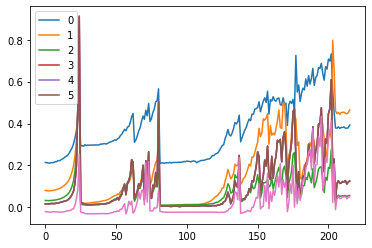

In [35]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

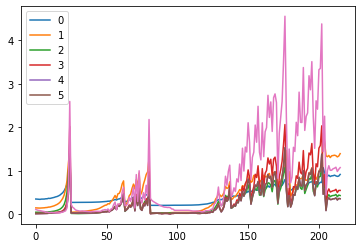

In [36]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

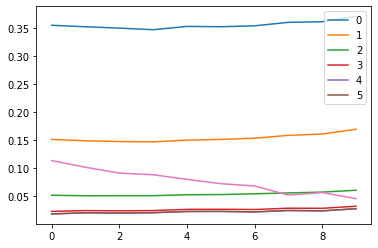

In [38]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

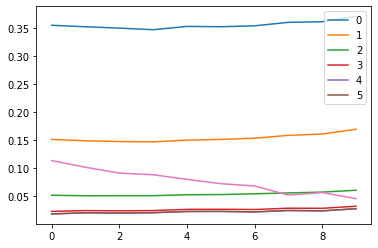

In [39]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

In [40]:
model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [41]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

In [42]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [44]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [45]:
run.fit(1, learn)

train: [1.6267140625, tensor(0.4468, device='cuda:0')]
valid: [0.3734240966796875, tensor(0.8882, device='cuda:0')]


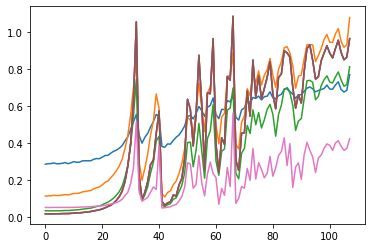

In [46]:
for o in act_means: plt.plot(o)

In [47]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    def __del__(self): self.remove()
        
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats=([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [48]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [50]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [51]:
run.fit(1, learn)

train: [2.0991090625, tensor(0.2588, device='cuda:0')]
valid: [1.50242470703125, tensor(0.4760, device='cuda:0')]


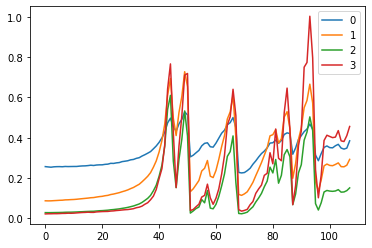

In [52]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));

In [60]:
#export
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [61]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [62]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [64]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True, False]]

([1, 2], [8])

In [65]:
#export
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
        
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [66]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [67]:
hooks = Hooks(model, append_stats)
hooks

Hooks (7 items)
[<__main__.Hook object at 0x7fb5cb28e908>, <__main__.Hook object at 0x7fb5cb28e080>, <__main__.Hook object at 0x7fb5bb4180b8>, <__main__.Hook object at 0x7fb5bb418dd8>, <__main__.Hook object at 0x7fb5bb418860>, <__main__.Hook object at 0x7fb5bb418e10>, <__main__.Hook object at 0x7fb5bb418eb8>]

In [68]:
hooks.remove()

In [69]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [70]:
x.mean(), x.std()

(tensor(0.0006, device='cuda:0'), tensor(0.9998, device='cuda:0'))

In [71]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.1639, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.2977, device='cuda:0', grad_fn=<StdBackward0>))

In [72]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [73]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.4966, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(1.0821, device='cuda:0', grad_fn=<StdBackward0>))

train: [2.11673359375, tensor(0.2828, device='cuda:0')]
valid: [1.2396755859375, tensor(0.5808, device='cuda:0')]
train: [0.75758109375, tensor(0.7528, device='cuda:0')]
valid: [0.327196630859375, tensor(0.8996, device='cuda:0')]


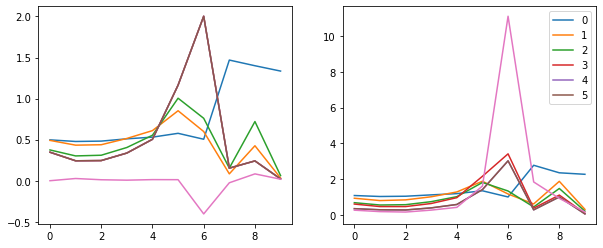

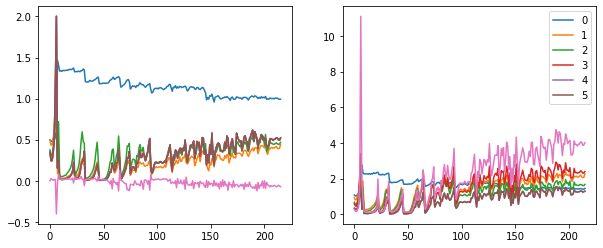

In [74]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));

In [75]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([], [], [])
    means,stds,hists = hook.stats
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [76]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [77]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [78]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [1.7731115625, tensor(0.3816, device='cuda:0')]
valid: [0.565050390625, tensor(0.8173, device='cuda:0')]


In [79]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

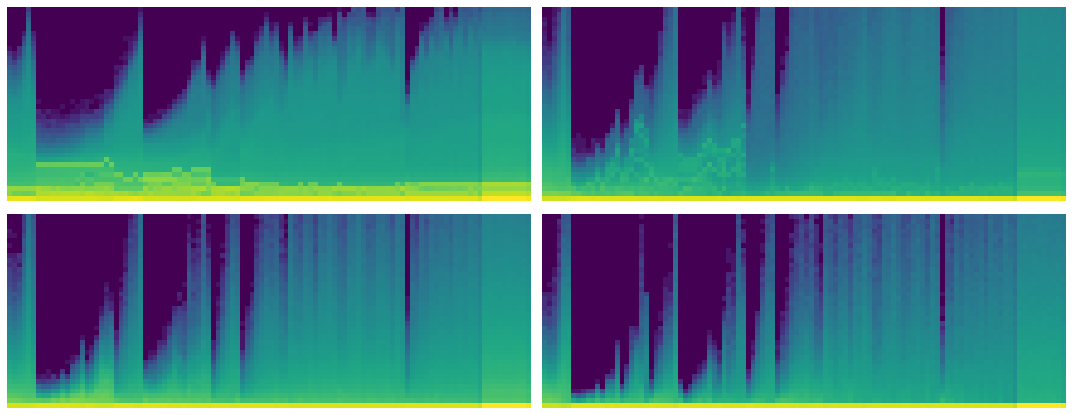

In [80]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [81]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0)

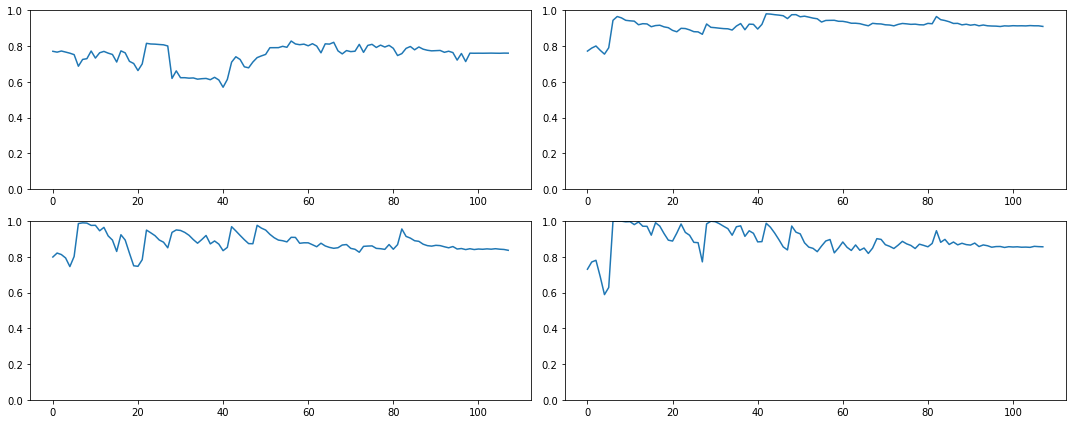

In [82]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [88]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [89]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [90]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.5037913671875, tensor(0.8418, device='cuda:0')]
valid: [0.147760498046875, tensor(0.9557, device='cuda:0')]


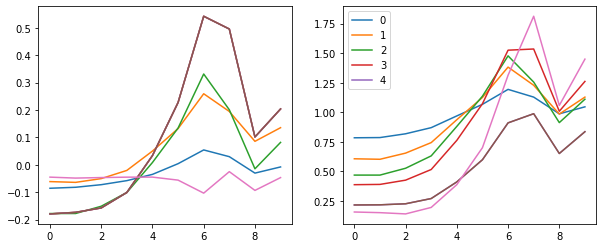

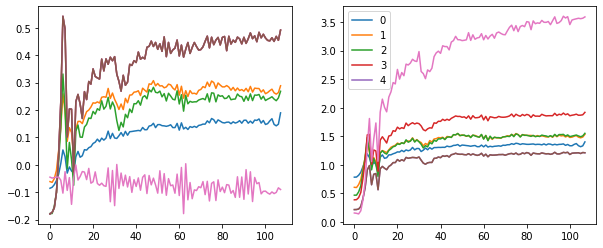

In [91]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

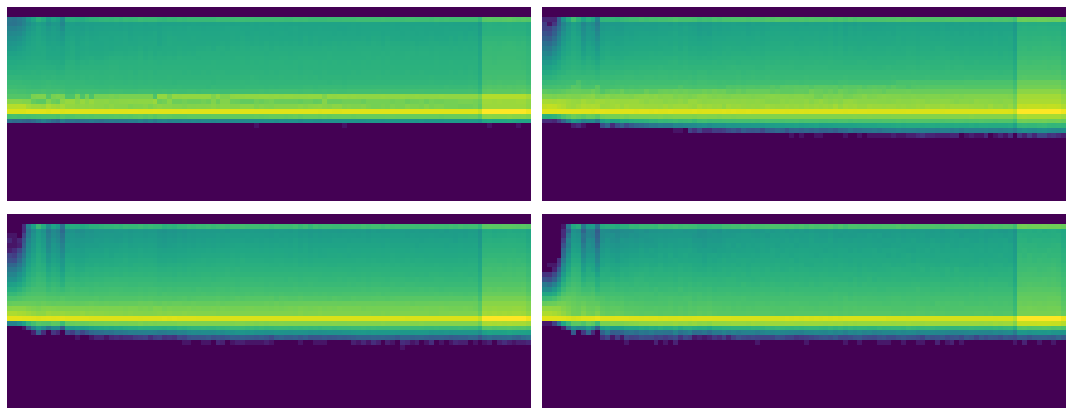

In [92]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [93]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

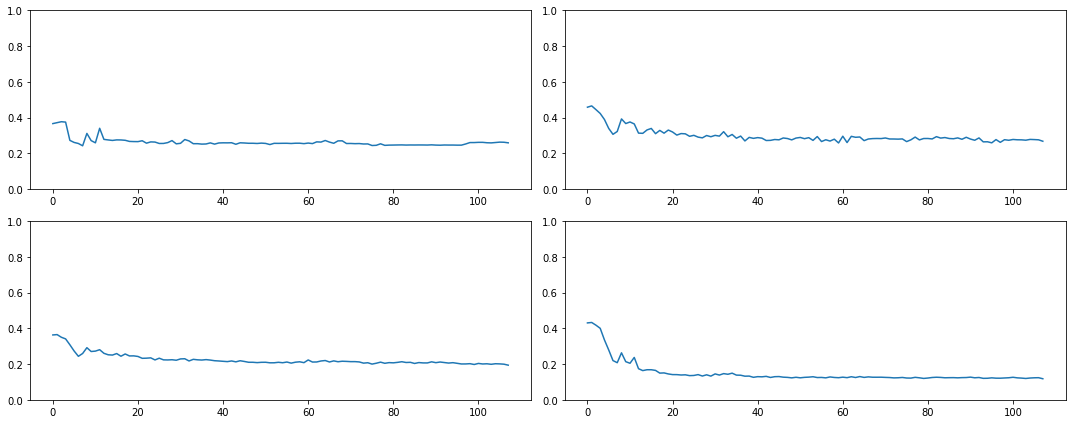

In [94]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [95]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [96]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)]) 

In [98]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [99]:
run.fit(8, learn)

train: [1.123533359375, tensor(0.6428, device='cuda:0')]
valid: [0.381757373046875, tensor(0.8823, device='cuda:0')]
train: [0.31210056640625, tensor(0.9007, device='cuda:0')]
valid: [0.19776822509765624, tensor(0.9378, device='cuda:0')]
train: [0.5315849609375, tensor(0.8360, device='cuda:0')]
valid: [0.13048311767578125, tensor(0.9622, device='cuda:0')]
train: [0.141896328125, tensor(0.9547, device='cuda:0')]
valid: [0.09162659912109375, tensor(0.9722, device='cuda:0')]
train: [0.0811716845703125, tensor(0.9748, device='cuda:0')]
valid: [0.07992139892578125, tensor(0.9777, device='cuda:0')]
train: [0.058149912109375, tensor(0.9816, device='cuda:0')]
valid: [0.06575786743164062, tensor(0.9809, device='cuda:0')]
train: [0.0443163623046875, tensor(0.9861, device='cuda:0')]
valid: [0.06020892333984375, tensor(0.9830, device='cuda:0')]
train: [0.03649786865234375, tensor(0.9888, device='cuda:0')]
valid: [0.06024329223632813, tensor(0.9834, device='cuda:0')]


In [100]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, uniform=True,
                          cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [101]:
run.fit(8, learn)

train: [1.2702446875, tensor(0.6129, device='cuda:0')]
valid: [0.397665625, tensor(0.8729, device='cuda:0')]
train: [0.28618845703125, tensor(0.9129, device='cuda:0')]
valid: [0.2156672119140625, tensor(0.9340, device='cuda:0')]
train: [0.956783359375, tensor(0.7024, device='cuda:0')]
valid: [0.6446330078125, tensor(0.7931, device='cuda:0')]
train: [0.2287291796875, tensor(0.9311, device='cuda:0')]
valid: [0.1263111572265625, tensor(0.9618, device='cuda:0')]
train: [0.11198583984375, tensor(0.9650, device='cuda:0')]
valid: [0.10049970092773437, tensor(0.9694, device='cuda:0')]
train: [0.0746500732421875, tensor(0.9770, device='cuda:0')]
valid: [0.07425264892578125, tensor(0.9770, device='cuda:0')]
train: [0.05752767578125, tensor(0.9824, device='cuda:0')]
valid: [0.07114935302734375, tensor(0.9783, device='cuda:0')]
train: [0.0483552490234375, tensor(0.9851, device='cuda:0')]
valid: [0.06985868530273437, tensor(0.9784, device='cuda:0')]


In [102]:
#export
from IPython.display import display, Javascript
def nb_auto_export():
    display(Javascript("""{
const ip = IPython.notebook
if (ip) {
    ip.save_notebook()
    console.log('a')
    const s = `!python notebook2script.py ${ip.notebook_name}`
    if (ip.kernel) { ip.kernel.execute(s) }
}
}"""))

In [ ]:
nb_auto_export()